## Cookbook: *PCA* analyses

As part of the `ipyrad.analysis` toolkit we've created convenience functions for easily performing exploratory principal component analysis (PCA) on your data. PCA is a very standard dimension-reduction technique that is often used to get a general sense of how samples are related to one another. PCA has the advantage over STRUCTURE type analyeses in that it is very fast. Similar to STRUCTURE, PCA can be used to produce simple and intuitive plots that can be used to guide downstream analysis. There are three very nice papers that talk about the application and interpretation of PCA in the context of population genetics:

[Reich et al (2008) Principal component analysis of genetic data](https://www.nature.com/articles/ng0508-491)

[Novembre & Stephens (2008) Interpreting principal component analyses of spatial population genetic variation](https://www.nature.com/articles/ng.139)

[McVean (2009) A genealogical interpretation of principal components analysis](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000686)



### A note on Jupyter/IPython
This is a Jupyter notebook, a reproducible and executable document. The code in this notebook is Python (2.7), and should be executed either in a jupyter-notebook, like this one, or in an IPython terminal. Execute each cell in order to reproduce our entire analysis. The example data set used in this analysis is from the [empirical example ipyrad tutorial](http://ipyrad.readthedocs.io/pedicularis_.html).

### Required software
You can easily install the required software for this notebook with a locally installed `conda` environment. Just run the commented code below in a terminal. If you are working on an HPC cluster you **do not need** administrator privileges to install the software in this way, since it is only installed locally.

In [1]:
## conda install ipyrad -c ipyrad
## conda install -c conda-forge scikit-allel

### Import Python libraries
The call to `%matplotlib inline` here enables support for plotting directly inside the notebook.

In [1]:
%matplotlib inline
import ipyrad
import ipyrad.analysis as ipa      ## ipyrad analysis toolkit

## Quick guide (tldr;)
The following cell shows the quickest way to results. Further explanation of all of the features and options is provided further below. 

loading Assembly: rad
from saved path: /tmp/ipyrad-test/rad.json
Using default cmap: Spectral


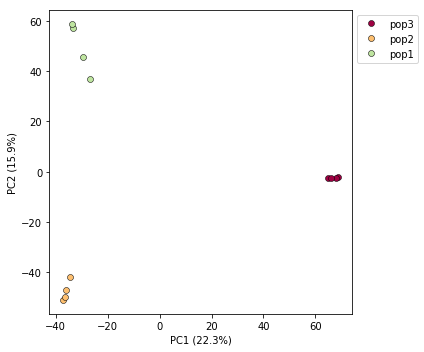

In [2]:
## Load your assembly
data = ipyrad.load_json("/tmp/ipyrad-test/rad.json")
## Create they pca object
pca = ipa.pca(data)
## Bam!
pca.plot()

# Full guide
In the most common use you'll want to plot the first two PCs, then inspect the output, remove any obvious outliers, and then redo the pca. It's often desirable to import a vcf file directly rather than to use the ipyrad assembly, so here we'll demonstrate this.

In [3]:
## Path to the input vcf, in this case it's just the vcf from our ipyrad pedicularis assembly
vcffile = "/home/isaac/ipyrad/test-data/pedicularis/ped_outfiles/ped.vcf"

Here we can just load the vcf file directly into the pca analysis module. Then ask for the samples in `samples_vcforder`, which is the order in which they are written in the vcf.

In [4]:
pca = ipa.pca(vcffile)
print(pca.samples_vcforder)

[u'29154_superba_SRR1754715' u'30556_thamno_SRR1754720'
 u'30686_cyathophylla_SRR1754730' u'32082_przewalskii_SRR1754729'
 u'33413_thamno_SRR1754728' u'33588_przewalskii_SRR1754727'
 u'35236_rex_SRR1754731' u'35855_rex_SRR1754726' u'38362_rex_SRR1754725'
 u'39618_rex_SRR1754723' u'40578_rex_SRR1754724'
 u'41478_cyathophylloides_SRR1754722' u'41954_cyathophylloides_SRR1754721']


Now construct the default plot, which shows all samples and PCs 1 and 2. By default all samples are assigned to one population, so everything will be the same color.

Using default cmap: Spectral


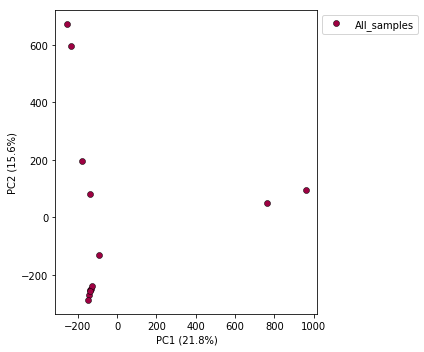

In [5]:
pca.plot()

## Population assignment for sample colors
In the tl;dr example the assembly of our simulated data had included a `pop_assign_file` so the pca() was smart enough to find this and color samples accordingly. In some cases you might not have used a pops file, so it's also possible to specify population assignments in a dictionary. The format of the dictionary should have populations as keys and lists of samples as values. Sample names need to be identical to the names in the vcf file, which we can verify with the `samples_vcforder` property of the pca object.

In [6]:
pops_dict = {
    "superba":["29154_superba_SRR1754715"],
    "thamno":["30556_thamno_SRR1754720", "33413_thamno_SRR1754728"],
    "cyathophylla":["30686_cyathophylla_SRR1754730"],
    "przewalskii":["32082_przewalskii_SRR1754729", "33588_przewalskii_SRR1754727"],
    "rex":["35236_rex_SRR1754731", "35855_rex_SRR1754726", "38362_rex_SRR1754725",\
            "39618_rex_SRR1754723", "40578_rex_SRR1754724"],
    "cyathophylloides":["41478_cyathophylloides_SRR1754722", "41954_cyathophylloides_SRR1754721"]
}

Using default cmap: Spectral


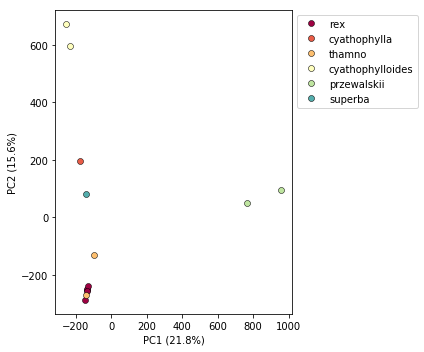

In [7]:
pca = ipa.pca(vcffile, pops_dict)
pca.plot()

This is just much nicer looking now, and it's also much more straightforward to interpret.

## Removing "bad" samples and replotting.
In PC analysis, it's common for "bad" samples to dominate several of the first PCs, and thus "pop out" in a degenerate looking way. Bad samples of this kind can often be attributed to poor sequence quality or sample misidentifcation. Samples with lots of missing data tend to pop way out on their own, causing distortion in the signal in the PCs. Normally it's best to evaluate the quality of the sample, and if it can be seen to be of poor quality, to remove it and replot the PCA. The Pedicularis dataset is actually very nice, and clean, but for the sake of demonstration lets imagine the cyathophylloides samples are "bad samples".

We can see that the cyathophylloides samples have particularly high values of PC2, so we can target them for removal in this way.

In [13]:
## pca.pcs is a property of the pca object that is populated after the plot() function is called. It contains
## the first 10 PCs for each sample. We construct a 'mask' based on the value of PC2, which here is the '1' in
## the first line of code (numpy arrays are 0-indexed and it's typical for PCs to be 1-indexed)
mask = pca.pcs.values[:, 1] > 500
print(mask)

## You can see here that the mask is a list of booleans that is the same length as the number of samples.
## We can use this list to print out the names of just the samples of interest
print(pca.samples_vcforder[mask])

[False False False False False False False False False False False  True
  True]
[u'41478_cyathophylloides_SRR1754722' u'41954_cyathophylloides_SRR1754721']


In [14]:
## We can then use this list of "bad" samples in a call to pca.remove_samples
## and then replot the new pca
pca.remove_samples(pca.samples_vcforder[mask])

## Lets prove that they're gone now
print(pca.samples_vcforder)

[u'29154_superba_SRR1754715' u'30556_thamno_SRR1754720'
 u'30686_cyathophylla_SRR1754730' u'32082_przewalskii_SRR1754729'
 u'33413_thamno_SRR1754728' u'33588_przewalskii_SRR1754727'
 u'35236_rex_SRR1754731' u'35855_rex_SRR1754726' u'38362_rex_SRR1754725'
 u'39618_rex_SRR1754723' u'40578_rex_SRR1754724']


Using default cmap: Spectral


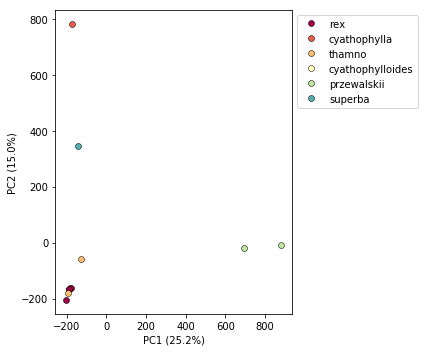

In [15]:
## and do the plot
pca.plot()

## Inspecting PCs directly
At any time after calling plot() you can inspect the PCs for all the samples using the `pca.pcs` property. The PC values are saved internally in a convenient pandas dataframe format.

In [17]:
pca.pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
29154_superba_SRR1754715,-143.458,344.601,-9.146,654.063,-71.953,-7.616,-19.466,44.390,-52.568,-8.116
30556_thamno_SRR1754720,-194.318,-181.059,-348.673,-94.304,-212.550,-492.266,-199.647,54.872,-71.137,-5.081
30686_cyathophylla_SRR1754730,-171.720,783.009,21.897,-354.809,23.015,-0.905,4.389,15.448,-19.187,-3.718
32082_przewalskii_SRR1754729,693.254,-18.583,-4.085,35.981,527.664,-210.055,-10.588,19.116,-22.978,-3.683
33413_thamno_SRR1754728,-126.793,-59.102,-29.833,24.647,4.006,-17.379,8.998,-339.049,438.306,-32.892
33588_przewalskii_SRR1754727,881.139,-8.878,5.835,-53.687,-434.127,170.774,6.425,3.491,-3.660,-1.877
35236_rex_SRR1754731,-187.931,-165.702,-163.637,-47.395,148.425,430.936,-459.261,35.808,-54.179,-5.964
35855_rex_SRR1754726,-184.338,-161.701,-164.247,-36.742,41.453,125.039,357.653,-286.551,-318.039,-8.572
38362_rex_SRR1754725,-201.661,-205.271,502.125,-54.539,-41.762,-76.632,-30.824,58.575,-66.826,-260.359
39618_rex_SRR1754723,-175.793,-160.807,368.111,-31.844,-28.502,-56.008,-17.545,16.067,-16.588,337.616


## Looking at PCs other than 1 & 2
PCs 1 and 2 by definition explain the most variation in the data, but sometimes PCs further down the chain can also be useful and informative. The plot function makes it simple to ask for PCs directly.

Using default cmap: Spectral


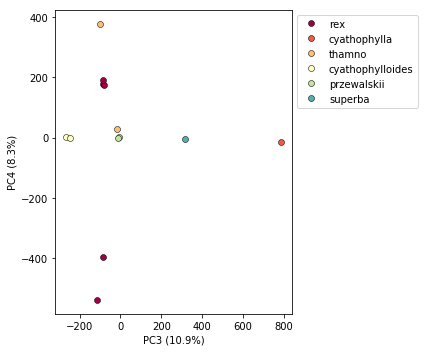

In [11]:
## Lets reload the full dataset so we have all the samples
pca = ipa.pca(vcffile, pops_dict)
pca.plot(pcs=[3,4])

Using default cmap: Spectral
Using default cmap: Spectral


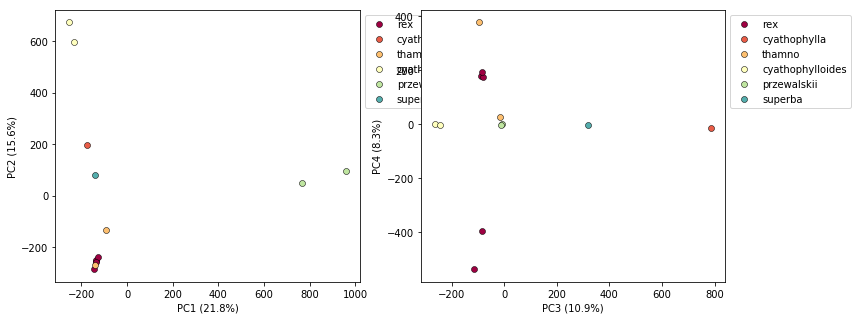

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

pca.plot(ax=ax1, pcs=[1, 2])
pca.plot(ax=ax2, pcs=[3, 4])

It's nice to see PCs 1-4 here, but it's kind of stupid to plot the legend twice, so we can just turn off the legend on the first plot.

Using default cmap: Spectral
Using default cmap: Spectral


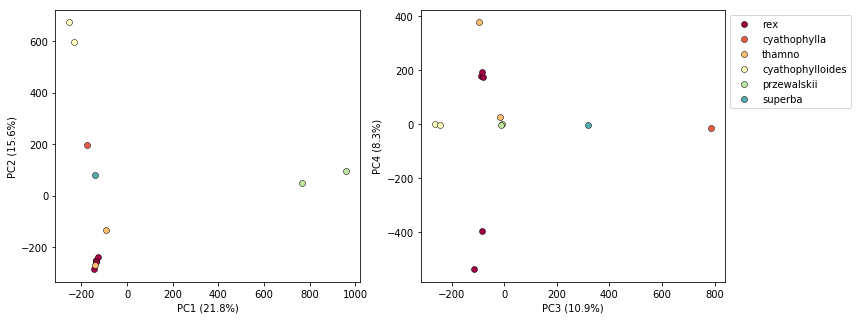

In [13]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

pca.plot(ax=ax1, pcs=[1, 2], legend=False)
pca.plot(ax=ax2, pcs=[3, 4])

## Controlling colors
You might notice the default color scheme is unobtrusive, but perhaps not to your liking. There are two ways of modifying the color scheme, one simple and one more complicated, but which gives extremely fine grained control over colors.

Colors for the more complicated method can be specified according to [python color conventions](https://matplotlib.org/users/colors.html). I find [this visual page of python color names useful](https://matplotlib.org/2.0.0/examples/color/named_colors.html).

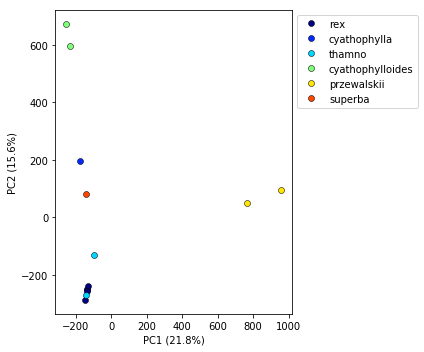

In [14]:
## Here's the simple way, just pass in a matplotlib cmap, or even better, the name of a cmap
pca.plot(cmap="jet")

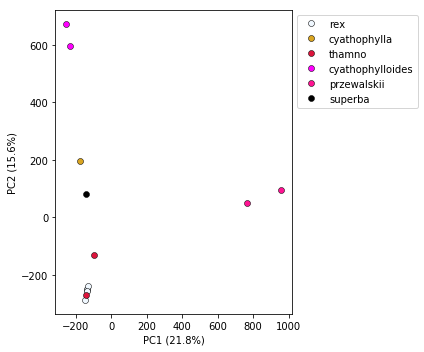

In [22]:
## Here's the harder way that gives you uber control. Pass in a dictionary mapping populations to colors.
my_colors = {
    "rex":"aliceblue",
    "thamno":"crimson",
    "przewalskii":"deeppink",
    "cyathophylloides":"fuchsia",
    "cyathophylla":"goldenrod",
    "superba":"black"
}
pca.plot(cdict=my_colors)

## Dealing with missing data
RAD-seq datasets are often characterized by moderate to high levels of missing data. While there may be many thousands or tens of thousands of loci recovered overall, the number of loci that are recovered in all sequenced samples is often quite small. The distribution of depth of coverage per locus is a complicated function of the size of the genome of the focal organism, the restriction enzyme(s) used, the size selection tolerances, and the sequencing effort. 

Both model-based (STRUCTURE and the like) and model-free (PCA/sNMF/etc) genetic "clustering" methods are sensitive to missing data. Light to moderate missing data that is distributed randomly among samples is often not enough to seriously impact the results. These are, after all, only exploratory methods. However, if missing data is biased in some way then it can distort the number of inferred populations and/or the relationships among these. For example, if several unrelated samples recover relatively few loci, for whatever reason (mistakes during library prep, failed sequencing, etc), clustering methods may erroniously identify this as true "similarity" with respect to the rest of the samples, and create spurious clusters.

In the end, all these methods must do something with sites that are uncalled in some samples. Some methods adopt a strategy of silently asigning missing sites the "Reference" base. Others, assign missing sites the average base. 

There are several ways of dealing with this:

 * One method is to simply __eliminate all loci with missing data__. This can be ok for SNP chip type data, where missingness is very sparse. For RAD-Seq type data, eliminating data for all missing loci often results in a drastic reduction in the size of the final data matrix. Assemblies with thousands of loci can be pared down to only tens or hundreds of loci.
 * Another method is to __impute missing data__. This is rarely done for RAD-Seq type data, comparatively speaking. Or at least it is rarely done intentionally. 
 * A third method is to __downsample using a hypergeometric projection__. This is the strategy adopted by dadi in the construction of the SFS (which abhors missing data). It's a little complicated though, so we'll only look at the first two strategies.

## Inspect the amount of missing data under various conditions
The pca module has various functions for inspecting missing data. The simples is the `get_missing_per_sample()` function, which does exactly what it says. It displays the number of ungenotyped snps per sample in the final data matrix. Here you can see that since we are using simulated data the amount of missing data is very low, but in real data these numbers will be considerable. 

In [4]:
pca.get_missing_per_sample()

1A_0    2
1B_0    2
1C_0    1
1D_0    4
2E_0    0
2F_0    0
2G_0    0
2H_0    1
3I_0    2
3J_0    2
3K_0    1
3L_0    2
dtype: int64

This is useful, but it doesn't give us a clear direction for how to go about dealing with the missingness. One way to reduce missing data is to reduce the tolerance for samples ungenotyped at a snp. The other way to reduce missing data is to remove samples with very poor sequencing. To this end, the `.missingness()` function will show a table of number of retained snps for various of these conditions.

In [3]:
pca.missingness()

,Full,2E_0,2F_0,2G_0,1C_0,2H_0
0,2547,2452,2313,2093,1958,1640
1,2553,2458,2319,2098,1963,1643
3,2554,2459,2320,2099,1963,1643
8,2555,2460,2321,2099,1963,1643


Here the columns indicate progressive removal of the samples with the fewest number of snps. So "Full" indicates retention of all samples. "2E_0" shows # snps after removing this sample (as it has the most missing data). "2F_0" shows the # snps after removing both this sample & "2E_0". And so on. You can see as we move from left to right the total number of snps goes down, but also so does the amount of missingness.

Rows indicate thresholds for number of allowed missing samples per snp. The "0" row shows the condition of allowing 0 missing samples, so this is the complete data matrix. The "1" row shows # of snps retained if you allow 1 missing sample. And so on.

### Filter by missingness threshold - trim_missing()

The `trim_missing()` function takes one argument, namely the maximum number of missing samples per snp. Then it removes all sites that don't pass this threshold.

In [7]:
pca.trim_missing(1)
pca.missingness()

,Full,1A_0,1B_0,1C_0,2E_0,2F_0
0,2547,2456,2282,2079,1985,1845
1,2553,2462,2286,2083,1989,1849


You can see that this also has the effect of reducing the amount of missingness per sample.

In [8]:
pca.get_missing_per_sample()

1A_0    0
1B_0    0
1C_0    0
1D_0    2
2E_0    0
2F_0    0
2G_0    0
2H_0    1
3I_0    1
3J_0    1
3K_0    0
3L_0    1
dtype: int64

__NB:__ This operation is _destructive_ of the data inside the pca object. It doesn't do anything to your data on file, though, so if you want to rewind you can just reload your vcf file.

In [9]:
## Voila. Back to the full dataset.
pca = ipa.pca(data)
pca.missingness()

,Full,2E_0,2F_0,2G_0,1C_0,2H_0
0,2547,2452,2313,2093,1958,1640
1,2553,2458,2319,2098,1963,1643
3,2554,2459,2320,2099,1963,1643
8,2555,2460,2321,2099,1963,1643


### Imputing missing genotypes
McVean (2008) recommends filling missing sites with the average genotype of the population, so that's what we're doing here. For each population, we determine the average genotype at any site with missing data, and then fill in the missing sites with this average. In this case, if the average "genotype" is "./.", then this is what gets filled in, so essentially any site missing more than 50% of the data isn't getting imputed. If two genotypes occur with equal frequency then the average is just picked as the first one.

In [12]:
pca.fill_missing()
pca.missingness()

,Full,2E_0,2F_0,2G_0,2H_0,1C_0
0,2553,2458,2319,2099,1779,1643
3,2554,2459,2320,2100,1780,1643
8,2555,2460,2321,2100,1780,1643


In comparing this missingness matrix with the previous one, you can see that indeed some snps are being recovered (though not many, again because of the clean simulated data). 

You can also examine the effect of imputation on the amount of missingness per sample. You can see it doesn't have as drastic of an effect as trimming, but it does have some effect, plus you are retaining more data!

In [11]:
pca.get_missing_per_sample()

1A_0    2
1B_0    2
1C_0    1
1D_0    2
2E_0    0
2F_0    0
2G_0    0
2H_0    0
3I_0    1
3J_0    1
3K_0    1
3L_0    1
dtype: int64

## Dealing with unequal sampling
Unequal sampling of populations can potentially distort PC analysis (see for example [Bradburd et al 2016](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005703)). Model based ancestry analysis suffers a similar limitation [Puechmaille 2016](https://onlinelibrary.wiley.com/doi/full/10.1111/1755-0998.12512)). McVean (2008) recommends downsampling larger populations, but nobody likes throwing away data. [Weighted PCA](https://www.asas.org/docs/default-source/wcgalp-proceedings-oral/210_paper_8713_manuscript_220_0.pdf?sfvrsn=2) was proposed, but has not been adopted by the community. 

In [18]:
{x:len(y) for x, y in pca.pops.items()}

{'cyathophylla': 1,
 'cyathophylloides': 2,
 'przewalskii': 2,
 'rex': 5,
 'superba': 1,
 'thamno': 2}

## Dealing with linked snps

In [ ]:

prettier_labels = {
    
    "32082_przewalskii":"przewalskii", 
    "33588_przewalskii":"przewalskii",
    "41478_cyathophylloides":"cyathophylloides", 
    "41954_cyathophylloides":"cyathophylloides", 
    "29154_superba":"superba",
    "30686_cyathophylla":"cyathophylla", 
    "33413_thamno":"thamno", 
    "30556_thamno":"thamno", 
    "35236_rex":"rex", 
    "40578_rex":"rex", 
    "35855_rex":"rex",
    "39618_rex":"rex", 
    "38362_rex":"rex"
}

### Copying this notebook to your computer/cluster
You can easily copy this notebook and then just replace my file names with your filenames to run your analysis. Just click on the [Download Notebook] link at the top of this page. Then run `jupyter-notebook` from a terminal and open this notebook from the dashboard.